The following script is built to synchronize footage from two cameras that also record audio with another separate microphone. In total there are three audio streams and two video streams. The goal is to synchronize the two video streams with each other and then synchronize the audio from the two video streams with the separate audio stream. 

In [36]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_audio
import sounddevice as sd
from pydub import AudioSegment
from moviepy.editor import VideoFileClip
import numpy as np
from pathlib import Path
import librosa
from scipy.signal import correlate, resample
import librosa
import os
from tqdm import tqdm
from IPython.display import Audio, Video
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import time
%matplotlib inline

In [3]:
sessionpath = Path('/Users/f004swn/Documents/SCRAP/data/group_tests/session2')
cam1_vid = sessionpath / 'cam1' / 'concatenated' / 'cam1_concatenated.mp4'
cam2_vid = sessionpath / 'cam2' / 'concatenated' / 'cam2_concatenated.mp4'
audiomix = sessionpath / 'audio' / 'mixed' / 'audio_mixed.wav'
audiomix, mix_sr = librosa.load(audiomix, sr=None)

derivative_path = sessionpath / 'derivates'
os.makedirs(str(derivative_path), exist_ok=True)

In [4]:
# extract audio from video files
def extract_audio(posix_video_path):
    print("Extracting audio from video files...\n")
    out_audio_path = str(derivative_path / str(os.path.basename(str(posix_video_path)[:-4]+'.wav')))
    ffmpeg_extract_audio(str(posix_video_path), out_audio_path)
    # librosa returns the numpy array as well as the sample rate
    return librosa.load(out_audio_path, sr=None)


In [5]:
def mix_audio(list_of_arrays):
    """
    Takes a list of numpy arrays and mixes them together, padding the shorter arrays with zeros.
    """
    # find the longest array
    max_len = max([len(arr) for arr in list_of_arrays])
    # pad the shorter arrays with zeros
    padded_arrays = [np.pad(arr, (0, max_len-len(arr)), 'constant') for arr in list_of_arrays]
    # sum the arrays
    return np.sum(padded_arrays, axis=0)


In [6]:
def window_rms(a, rate=44100, window_ms=100):
    """
    Takes a numpy array representing audio and returns rolling-window root-mean-squared value.
    """
    window_size = int(round((rate/1000)*window_ms))
    ashape = a.shape[0]
    a2 = np.power(a,2)
    window = np.ones(window_size)/float(window_size)
    rms_out = np.sqrt(np.convolve(a2, window, 'same'))
    rms_out = resample(rms_out, ashape)
    return  rms_out

In [7]:
def plot_rms(rms_array, maxlen):
    plt.figure(figsize=(20,5))
    plt.plot(rms_array)
    plt.xlim(0, maxlen)
    plt.show()

In [8]:
video_files = [cam1_vid, cam2_vid]
audio_files = [extract_audio(vid) for vid in tqdm(video_files)]

  0%|          | 0/2 [00:00<?, ?it/s]

Extracting audio from video files...

Moviepy - Running:
>>> "+ " ".join(cmd)


  0%|          | 0/2 [00:31<?, ?it/s]

Moviepy - Command successful


 50%|█████     | 1/2 [00:34<00:34, 34.23s/it]

Extracting audio from video files...

Moviepy - Running:
>>> "+ " ".join(cmd)


 50%|█████     | 1/2 [00:41<00:34, 34.23s/it]

Moviepy - Command successful


100%|██████████| 2/2 [00:43<00:00, 21.57s/it]


In [9]:
# Unpack the audio files
audio1, sr1 = audio_files[0]
audio2, sr2 = audio_files[1]

In [73]:
# resample mix to match the sample rate of the audio files extracted from the GoPros
# audiomix = librosa.resample(audiomix, orig_sr=mix_sr,  target_sr=sr1)

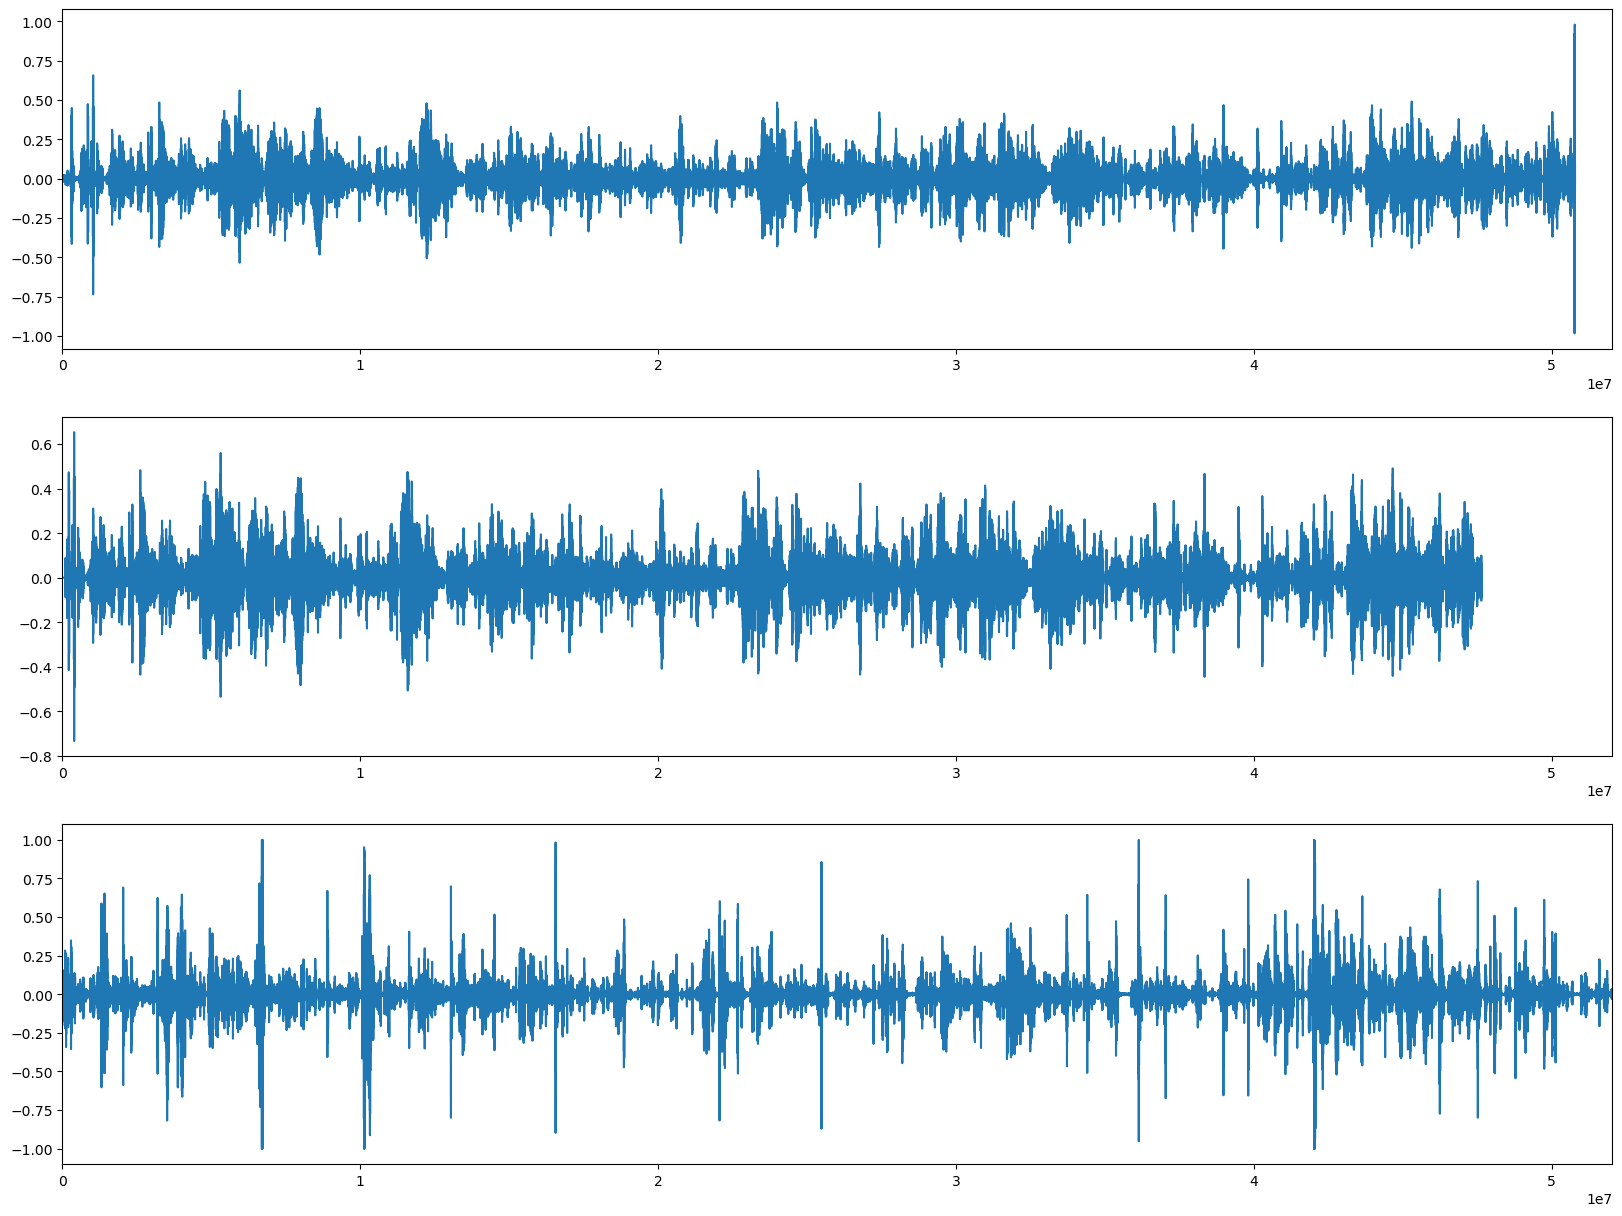

In [15]:
def plot_all(list_of_arrays):
    maxlen = max([i.shape[0] for i in list_of_arrays])
    n_arrays = len(list_of_arrays)
    fig, axs = plt.subplots(n_arrays, figsize=(20,5*n_arrays))
    for a, arr in enumerate(list_of_arrays):
        axs[a].plot(arr)
        axs[a].set_xlim(0, maxlen)
plot_all([audio1, audio2, audiomix])

In [47]:
# Cross-correlate each audio stream with the mix
# The output array represents how similar the two signals are at each time step
# Here, the audio files are different lengths, so the output array is longer than either of the input arrays
# To address this, I'm going to pad the shorter audio file with zeros

correlation1 = correlate(audio1, audiomix, mode='full')
correlation2 = correlate(audio2, audiomix, mode='full')

cam1_frameshift = np.argmax(correlation1)
cam2_frameshift = np.argmax(correlation2)
print(cam1_frameshift / 44100)
print(cam2_frameshift / 44100)

1223.9740362811792
1209.514195011338


In [ ]:
# Cross-correlate each audio stream with the mix
# The output array represents how similar the two signals are at each time step
# Here, the audio files are different lengths, so the output array is longer than either of the input arrays
# To address this, I'm going to pad the shorter audio file with zeros

corr = correlate(audio1, audio2, mode='full')

In [59]:
shift = np.argmax(corr) - len(audio1)
ad2_shifted = np.roll(audio2, shift)
#plot_all([audio1, np.roll(audio2, shift)])
aamix = mix_audio([audio1, ad2_shifted])

In [61]:
sd.stop()

In [52]:
def align_audio(list_of_camera_audio_arrays, microphone_mix, chop_to_shortest=False):
    """
    Takes a list of numpy arrays representing audio from each camera and a numpy array representing the microphone mix.
    Returns a list of numpy arrays representing the aligned audio from each camera.
    """
    # cross-correlate each audio stream with the mix
    # the output array represents how similar the two signals are at each time step
    all_arrays = list_of_camera_audio_arrays + [microphone_mix]
    # find the longest array
    max_pos = np.argmax(np.array([len(arr) for arr in all_arrays]))
    maxlen = len(all_arrays[max_pos])
    if max_pos == len(all_arrays) - 1:
        microphone_is_longest = True
    else:
        microphone_is_longest = False
    del all_arrays
    # pad the shorter arrays with zeros    
    list_of_camera_audio_arrays = [np.pad(arr, (0, maxlen-len(arr)), 'constant') for arr in list_of_camera_audio_arrays]
    microphone_mix = np.pad(microphone_mix, (0, maxlen-len(microphone_mix)), 'constant')
    # cross-correlate each array with the microphone mix
    print("Cross-correlating audio streams with microphone mix...\n")
    correlations = [correlate(arr, microphone_mix, mode='full') for arr in list_of_camera_audio_arrays]
    # find the time shift (in seconds) that maximizes the correlation
    print("Finding time shift that maximizes correlation...\n")
    shifts = [np.argmax(corr) - len(arr) for corr, arr in zip(correlations, list_of_camera_audio_arrays)]
    # shift the audio streams
    print("Shifting audio streams...\n")
    if microphone_is_longest:
        shifted_audio = [np.roll(arr, -shift) for arr, shift in zip(list_of_camera_audio_arrays, shifts)]
    else:
        shifted_audio = [np.roll(arr, shift) for arr, shift in zip(list_of_camera_audio_arrays, shifts)]
    
    return shifted_audio + [microphone_mix]
    


    # begin plotting block
    # print("Plotting alignment...\n")
    # fig, axs = plt.subplots(len(outputs), figsize=(20,5*len(outputs)))
    # for a, arr in enumerate(outputs):
    #     axs[a].plot(arr, alpha=0.5, color='green')
    #     axs[a].plot(all_arrays[a], alpha=0.5, color='red')
    #     axs[a].set_xlim(0, maxlen)
    # # making color legend
    # red_patch = mpatches.Patch(color='red', label='Original')
    # green_patch = mpatches.Patch(color='green', label='Aligned')
    # plt.legend(handles=[red_patch, green_patch])
    # plt.show()

Cross-correlating audio streams with microphone mix...
Finding time shift that maximizes correlation...

Shifting audio streams...


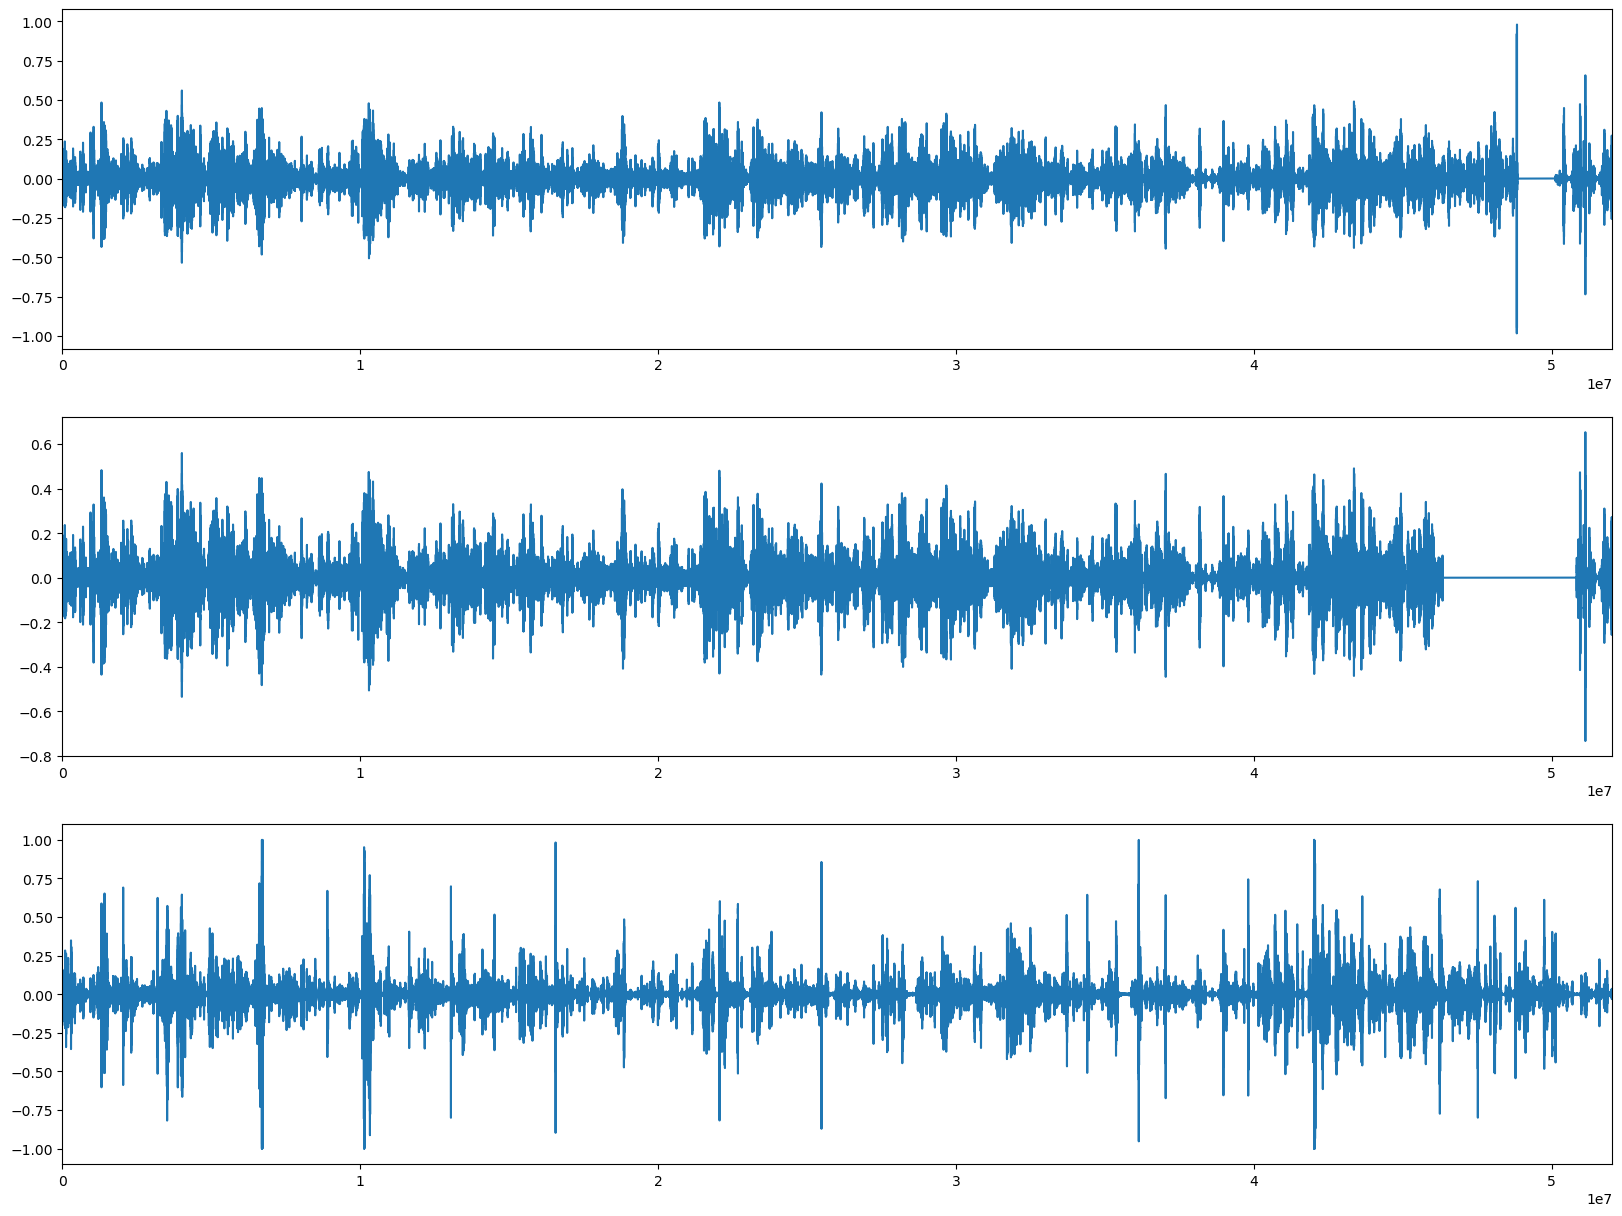

In [53]:
output = align_audio([audio1, audio2], audiomix)
plot_all(output)

sd.play(mix_audio(output), sr1)
time.sleep(5)
sd.stop()

In [17]:
all_aligned = align_audio([audio1, audio2], audiomix)

Cross-correlating audio streams with microphone mix...
Finding time shift that maximizes correlation...

Shifting audio streams...


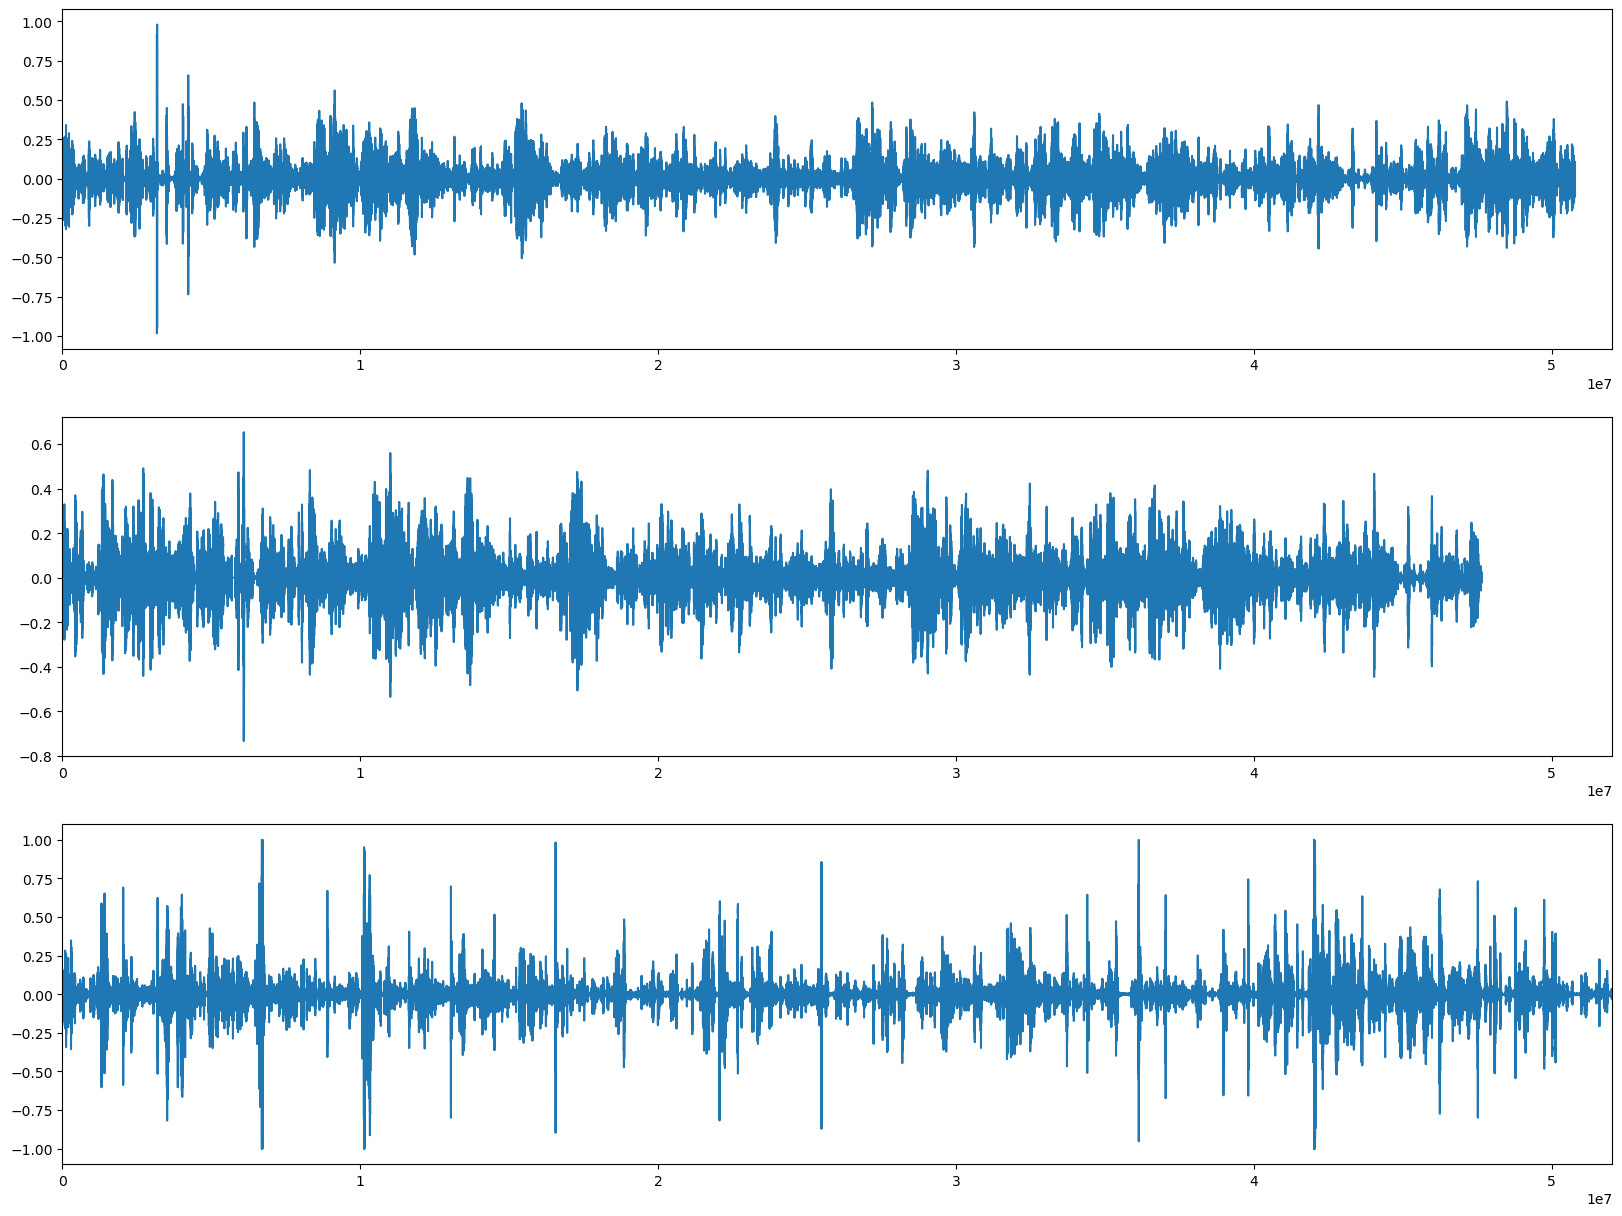

In [18]:
# plot the aligned audio
plot_all(all_aligned)

In [13]:
sd.play(mix_audio(all_aligned), sr1)

In [14]:
sd.stop()

In [15]:
audio1_frameshift = (np.argmax(correlation1) - len(audio1))
print(audio1_frameshift)
audio2_frameshift = (np.argmax(correlation2) - len(audio2))
print(audio2_frameshift)

3191930
5694641


In [21]:
# find longest audio file
max_len = max([len(audio1), len(audio2), len(audiomix)])
# pad the shorter arrays with zeros
audio1 = np.pad(audio1, (0, max_len-len(audio1)), 'constant')
audio2 = np.pad(audio2, (0, max_len-len(audio2)), 'constant')
audiomix = np.pad(audiomix, (0, max_len-len(audiomix)), 'constant')

In [26]:
mastermix = mix_audio([audio1, audio2, audiomix])
sd.play(mastermix, sr1)

In [27]:
sd.stop()

In [60]:
cam1_timeshift

72.43315192743763

In [61]:
cam2_timeshift

129.1821768707483

In [31]:
# Now I'm going to align the two video files with each other using the time_shift_seconds
# I'm going to use moviepy to do this
clip1 = VideoFileClip(str(cam1_vid)).subclip(cam1_timeshift)
clip2 = VideoFileClip(str(cam2_vid)).subclip(cam2_timeshift)

I want to chop off either the ending or the beginning of the two clips (audio *or* video) that are longer than the shortest clip

In [36]:
# find the shortest clip
cam1_dur = audio1.shape[0] / sr1 / 60
cam2_dur = audio2.shape[0] / sr2 / 60
mix_dur = audiomix.shape[0] / sr1 / 60

In [37]:
print(f'cam1 duration: {cam1_dur:.2f} minutes')
print(f'cam2 duration: {cam2_dur:.2f} minutes')
print(f'mix duration: {mix_dur:.2f} minutes')

cam1 duration: 19.19 minutes
cam2 duration: 18.01 minutes
mix duration: 19.67 minutes


In [38]:
# the following function finds the shortest file in terms of duration and cuts off the over- and under-hangs of the other two files to match the shortest file
def cut_to_shortest(clip1, clip2, audiomix):
    # find the shortest clip
    cam1_dur = clip1.duration
    cam2_dur = clip2.duration
    mix_dur = librosa.get_duration(y=audiomix, sr=sr1)
    shortest_dur = min(cam1_dur, cam2_dur, mix_dur)
    # cut off the overhangs
    if cam1_dur > shortest_dur:
        clip1 = clip1.subclip(0, shortest_dur)
    elif cam2_dur > shortest_dur:
        clip2 = clip2.subclip(0, shortest_dur)
    elif mix_dur > shortest_dur:
        audiomix = audiomix[:int(shortest_dur*sr1)]
    return clip1, clip2, audiomix

In [39]:
clip1, clip2, audiomix = cut_to_shortest(clip1, clip2, audiomix)

In [40]:
# Now I export the two clips and the audio mix
clip1.write_videofile(str(derivative_path / 'cam1_synced.mp4'), codec='libx264', audio_codec='aac')
clip2.write_videofile(str(derivative_path / 'cam2_synced.mp4'), codec='libx264', audio_codec='aac')
librosa.output.write_wav(str(derivative_path / 'mix_synced.wav'), audiomix, sr1)

Moviepy - Building video /Users/f004swn/Documents/SCRAP/data/group_tests/session2/derivates/cam1_synced.mp4.
MoviePy - Writing audio in cam1_syncedTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /Users/f004swn/Documents/SCRAP/data/group_tests/session2/derivates/cam1_synced.mp4


t:   3%|▎         | 1759/57020 [00:53<38:24, 23.98it/s, now=None]

KeyboardInterrupt: 